In [22]:
import pandas as pd
import numpy as np

# Different possible regression models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.dummy import DummyRegressor

# Other process packages
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
# import statsmodels

# Model scoring and assessment packages
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
import shap

# Model optimization packages
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats

# Visualization packages
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import plotly.graph_objects as go

Helper functions

In [23]:
def plot_permutation_importance(clf,
                                X:pd.DataFrame,
                                y:pd.Series,
                                scoring:list,
                                random_state:int,
                                ax):
    '''
    From https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py
    This function uses sklearn's permutation importance function to generate a plot showing
    the permutation importances of the test set.
    '''
    result = permutation_importance(clf,
        X,
        y,
        scoring=scoring,
        n_repeats=10,
        random_state=random_state,
        n_jobs=-1)
    perm_sorted_idx = result.importances_mean.argsort()

    ax.boxplot(result.importances[perm_sorted_idx].T,
        vert=False,
        labels=X.columns[perm_sorted_idx])
    ax.set_title("Permutation Importances (test set)")
    ax.set_xlabel(scoring)

    fig.tight_layout()
    plt.show()

    return ax

def display_feature_importance(clf,
                               X_train:pd.DataFrame,
                               X_test:pd.DataFrame,
                               y_train:pd.Series,
                               y_test:pd.Series):
    '''
    Borrowed from sklearn - link unknown
    This function displays feature importance of a model and also outputs permutation importance.
    '''

    results = pd.Series(
        clf.feature_importances_,
        index=clf.feature_names_in_,
        ).sort_values(ascending=False)
    print("Feature Importance Ranking:\n", results.index)
    results.plot.bar(figsize=(15, 5))
    r = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
    for i in r.importances_mean.argsort()[::-1]:
        if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
            print(f"{clf.feature_names_in_[i]:<8}"
                f"{r.importances_mean[i]:.3f}"
                f" +/- {r.importances_std[i]:.3f}")
    mdi_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 8))
    mdi_importances.sort_values().plot.barh(ax=ax1)
    ax1.set_xlabel("Gini Importance")
    plot_permutation_importance(clf, X_train, y_train, "neg_mean_absolute_error", 42, ax2)
    ax2.set_xlabel("Decrease in neg_mean_absolute_error")
    # fig.subtitle(
    #     "Impurity-based Feature Importance vs Permutation Importances /n on multicolinear features (train set)")
    _ = fig.tight_layout()
    
    fig, ax = plt.subplots(figsize=(12, 8))
    plot_permutation_importance(clf, X_test, y_test, "neg_mean_absolute_error", 42, ax)
    ax.set_title("Permutation Importances (test set)")
    ax.set_xlabel("Decrease in neg_mean_absolute_error")
    _ = ax.figure.tight_layout()
    plt.show()

def transformed_train_test_split(X,
                                 y,
                                 test_size,
                                 random_state,
                                 pipe,
                                 groups,
                                 ):
    X_train_, X_test_, y_train_, y_test_ = train_test_split(X,
                                                      y,
                                                      test_size=test_size,
                                                      random_state=50,
                                                      stratify=groups)
    '''
    This function applied pipeline transformations to the X train and test sets after fitting to the X_train set.
    The y test and train sets also have a natural log +1 transformation to correct for skewness.
    '''
    # Fit pipeline to X_train_ and then transform X_train and X_test
    groups_train = X_train_['category']
    pipe.fit(X_train_)
    X_train = pipe.transform(X_train_)
    X_test = pipe.transform(X_test_)

    # Apply natural log transform to both y_train and y_test
    y_train = np.log1p(y_train_)
    y_test = np.log1p(y_test_)

    return X_train, X_test, y_train, y_test, groups_train

Read in the main dataset and drop unnecessary columns.

In [24]:
df = pd.read_csv('final_merge.csv',
    index_col=0)
print(f'Dataframe shape: {df.shape}')
print(f'dataframe columns: {df.columns}')

# Drop columns with Percent to avoid duplication with Estimate columns
df = df[df.columns.drop(list(df.filter(regex='Percent')))]

print(f'dataframe columns after drop: {df.columns}')



Dataframe shape: (1730, 54)
dataframe columns: Index(['disasterNumber', 'declarationTitle', 'state', 'Date_x',
       'fipsStateCode', 'fipsCountyCode', 'year', 'county', 'validReg_own',
       'DamageBetween1and1000', 'DamageBetween10001and2000',
       'DamageBetween20001and3000', 'DamageGreaterThan3000', 'validReg_rent',
       'ModerateDamage_rent', 'MajorDamage_rent', 'SubstDamage_rent',
       'fipsCode', 'LATITUDE_county', 'LONGITUDE_county',
       'Geographic Area Name',
       'Estimate!!HOUSING OCCUPANCY!!Total housing units',
       'Percent!!HOUSING OCCUPANCY!!Total housing units',
       'Estimate!!HOUSING OCCUPANCY!!Total housing units!!Occupied housing units',
       'Percent!!HOUSING OCCUPANCY!!Total housing units!!Occupied housing units',
       'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2020 or later',
       'Percent!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2020 or later',
       'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2

Review the dataframe.

In [25]:
df.head()

,disasterNumber,declarationTitle,state,Date_x,fipsStateCode,fipsCountyCode,year,county,validReg_own,DamageBetween1and1000,...,Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1939 or earlier,Name,Date_y,Latitude,Longitude,Max Wind,Max Pressure,Landfall_Lat,Landfall_Lon,dist_from_landfall
0,4798,HURRICANE BERYL,TX,2024-07-05 00:00:00+00:00,48,15,2024,Austin (County),582.0,100.0,...,1147,BERYL,20240708,28.6N,96.0W,80,978,28.6,-96.0,87.175749
1,4798,HURRICANE BERYL,TX,2024-07-05 00:00:00+00:00,48,37,2024,Bowie (County),495.0,36.0,...,1384,BERYL,20240708,28.6N,96.0W,80,978,28.6,-96.0,349.863220
2,4798,HURRICANE BERYL,TX,2024-07-05 00:00:00+00:00,48,39,2024,Brazoria (County),44176.0,5499.0,...,1766,BERYL,20240708,28.6N,96.0W,80,978,28.6,-96.0,63.975663
3,4798,HURRICANE BERYL,TX,2024-07-05 00:00:00+00:00,48,71,2024,Chambers (County),3431.0,417.0,...,333,BERYL,20240708,28.6N,96.0W,80,978,28.6,-96.0,111.469171
4,4798,HURRICANE BERYL,TX,2024-07-05 00:00:00+00:00,48,157,2024,Fort Bend (County),79137.0,4907.0,...,2457,BERYL,20240708,28.6N,96.0W,80,978,28.6,-96.0,72.859249


In [26]:
df.describe()

,disasterNumber,fipsStateCode,fipsCountyCode,year,validReg_own,DamageBetween1and1000,DamageBetween10001and2000,DamageBetween20001and3000,DamageGreaterThan3000,validReg_rent,...,Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1960 to 1969,Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1950 to 1959,Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1940 to 1949,Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1939 or earlier,Date_y,Max Wind,Max Pressure,Landfall_Lat,Landfall_Lon,dist_from_landfall
count,1730.000000,1730.000000,1730.000000,1730.000000,1713.000000,1713.000000,1713.000000,1713.000000,1713.000000,1689.000000,...,1730.000000,1730.000000,1730.000000,1730.000000,1.730000e+03,1730.000000,1730.000000,1730.000000,1730.000000,1730.000000
mean,3094.516763,31.530636,108.391908,2012.023699,6090.835960,1841.802685,155.615295,53.805604,66.267951,4555.212552,...,7281.291908,4995.699422,2400.882081,2139.339306,2.012114e+07,97.234104,953.211561,28.673815,-82.800289,236.829505
std,1458.354903,20.591525,119.229293,7.755594,17289.765569,5212.056569,784.883876,372.534664,511.160118,19365.789881,...,16648.966254,12298.887890,6137.119990,5229.259202,7.756742e+04,19.661540,17.364006,4.368017,7.763506,250.074421
min,1479.000000,1.000000,1.000000,2003.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,39.000000,41.000000,-71.000000,-61.000000,2.003072e+07,65.000000,919.000000,18.000000,-97.200000,4.543943
25%,1554.000000,12.000000,43.000000,2004.000000,324.000000,138.000000,2.000000,0.000000,0.000000,106.000000,...,1129.750000,709.250000,357.250000,371.000000,2.004092e+07,80.000000,939.000000,27.200000,-87.900000,81.909737
50%,4019.000000,28.000000,83.000000,2011.000000,1359.000000,464.000000,15.000000,2.000000,2.000000,581.000000,...,2273.000000,1424.500000,768.000000,790.500000,2.011083e+07,95.000000,952.000000,29.300000,-82.200000,152.902961
75%,4400.000000,48.000000,123.000000,2018.000000,4862.000000,1434.000000,73.000000,13.000000,13.000000,2471.000000,...,5992.000000,3657.750000,1880.500000,1896.250000,2.018101e+07,110.000000,965.000000,30.200000,-79.500000,270.123505
max,4834.000000,72.000000,840.000000,2024.000000,331674.000000,99520.000000,23576.000000,11003.000000,11077.000000,374677.000000,...,240198.000000,145008.000000,99878.000000,63843.000000,2.024101e+07,140.000000,986.000000,34.900000,-65.900000,1312.120049


Merge this dataset with storm information about the closest pass for each observation.

In [27]:
# Rename one column to make merging easier.
df['declarationTitle'].rename('Name')

# Remove HURRICANE from all hurricane names for merging purposes.
df['Name'] = df['Name'].str.replace('HURRICANE ', '')
df.columns

Index(['disasterNumber', 'declarationTitle', 'state', 'Date_x',
       'fipsStateCode', 'fipsCountyCode', 'year', 'county', 'validReg_own',
       'DamageBetween1and1000', 'DamageBetween10001and2000',
       'DamageBetween20001and3000', 'DamageGreaterThan3000', 'validReg_rent',
       'ModerateDamage_rent', 'MajorDamage_rent', 'SubstDamage_rent',
       'fipsCode', 'LATITUDE_county', 'LONGITUDE_county',
       'Geographic Area Name',
       'Estimate!!HOUSING OCCUPANCY!!Total housing units',
       'Estimate!!HOUSING OCCUPANCY!!Total housing units!!Occupied housing units',
       'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2020 or later',
       'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2010 to 2019',
       'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2000 to 2009',
       'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1990 to 1999',
       'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1980 to 1989',
       'E

In [28]:
# Load the data to be merged and rename columns to be more specific.
df_closest_pass = pd.read_csv('closest_pass.csv')
df_closest_pass.rename(columns={'Max Wind':'Closest_Max_Wind', 
                                'Max Pressure':'Closest_Max_Pressure'}, inplace=True)
print(df_closest_pass.shape)
df_closest_pass.head()


(1730, 7)


,Name,year,Closest_Max_Wind,Closest_Max_Pressure,fipsCode,distance_from_storm,category
0,BERYL,2024,70,978,48015,40.192025,TS
1,BERYL,2024,25,1004,48037,6.349638,TD
2,BERYL,2024,70,978,48039,37.310013,TS
3,BERYL,2024,50,988,48071,79.163470,TS
4,BERYL,2024,70,978,48157,29.248125,TS


In [29]:
# Merge the original dataframe with the closest pass storm information for each observation.
df = pd.merge(left=df, right=df_closest_pass, on=['Name', 'year', 'fipsCode'])
print(df.shape)
df.head()

(1730, 46)


,disasterNumber,declarationTitle,state,Date_x,fipsStateCode,fipsCountyCode,year,county,validReg_own,DamageBetween1and1000,...,Longitude,Max Wind,Max Pressure,Landfall_Lat,Landfall_Lon,dist_from_landfall,Closest_Max_Wind,Closest_Max_Pressure,distance_from_storm,category
0,4798,HURRICANE BERYL,TX,2024-07-05 00:00:00+00:00,48,15,2024,Austin (County),582.0,100.0,...,96.0W,80,978,28.6,-96.0,87.175749,70,978,40.192025,TS
1,4798,HURRICANE BERYL,TX,2024-07-05 00:00:00+00:00,48,37,2024,Bowie (County),495.0,36.0,...,96.0W,80,978,28.6,-96.0,349.863220,25,1004,6.349638,TD
2,4798,HURRICANE BERYL,TX,2024-07-05 00:00:00+00:00,48,39,2024,Brazoria (County),44176.0,5499.0,...,96.0W,80,978,28.6,-96.0,63.975663,70,978,37.310013,TS
3,4798,HURRICANE BERYL,TX,2024-07-05 00:00:00+00:00,48,71,2024,Chambers (County),3431.0,417.0,...,96.0W,80,978,28.6,-96.0,111.469171,50,988,79.163470,TS
4,4798,HURRICANE BERYL,TX,2024-07-05 00:00:00+00:00,48,157,2024,Fort Bend (County),79137.0,4907.0,...,96.0W,80,978,28.6,-96.0,72.859249,70,978,29.248125,TS


Perform a similar process to add county-level cluster information to our main dataframe by merging on fipsCode

In [30]:
df_clusters = pd.read_csv('clusters_n_2.csv',
    index_col=0)
print(df_clusters.shape)
print(df_clusters.describe())
df_clusters.head()


(1745, 3)
           fipsCode  housing_cluster  econ_cluster
count   1745.000000      1745.000000   1719.000000
mean   31804.100287         0.009742      0.111693
std    20629.798423         0.098248      0.315080
min     1001.000000         0.000000      0.000000
25%    12119.000000         0.000000      0.000000
50%    28045.000000         0.000000      0.000000
75%    48095.000000         0.000000      0.000000
max    72153.000000         1.000000      1.000000


,fipsCode,housing_cluster,econ_cluster
0,48015,0,0.0
1,48015,0,0.0
2,48015,0,0.0
3,48037,0,0.0
4,48039,0,0.0


Identify the duplicate rows.

In [31]:
duplicate_rows = df_clusters[df_clusters.duplicated()]
duplicate_rows

,fipsCode,housing_cluster,econ_cluster
1,48015,0,0.0
2,48015,0,0.0
5,48039,0,0.0
6,48039,0,0.0
7,48039,0,0.0
...,...,...,...
1570,37121,0,0.0
1572,37149,0,0.0
1574,37161,0,0.0
1577,37189,0,0.0


Drop the duplicate rows.

In [32]:
df_clusters = df_clusters.drop_duplicates()

Merge with the clusters found in the Unsupervised Learning process.

In [33]:
# Merge the original dataframe with the closest pass storm information for each observation.
df = pd.merge(left=df,
              right=df_clusters,
              on=['fipsCode'],
              how='left')
print(df.shape)
df.head()

(1730, 48)


,disasterNumber,declarationTitle,state,Date_x,fipsStateCode,fipsCountyCode,year,county,validReg_own,DamageBetween1and1000,...,Max Pressure,Landfall_Lat,Landfall_Lon,dist_from_landfall,Closest_Max_Wind,Closest_Max_Pressure,distance_from_storm,category,housing_cluster,econ_cluster
0,4798,HURRICANE BERYL,TX,2024-07-05 00:00:00+00:00,48,15,2024,Austin (County),582.0,100.0,...,978,28.6,-96.0,87.175749,70,978,40.192025,TS,0,0.0
1,4798,HURRICANE BERYL,TX,2024-07-05 00:00:00+00:00,48,37,2024,Bowie (County),495.0,36.0,...,978,28.6,-96.0,349.863220,25,1004,6.349638,TD,0,0.0
2,4798,HURRICANE BERYL,TX,2024-07-05 00:00:00+00:00,48,39,2024,Brazoria (County),44176.0,5499.0,...,978,28.6,-96.0,63.975663,70,978,37.310013,TS,0,0.0
3,4798,HURRICANE BERYL,TX,2024-07-05 00:00:00+00:00,48,71,2024,Chambers (County),3431.0,417.0,...,978,28.6,-96.0,111.469171,50,988,79.163470,TS,0,0.0
4,4798,HURRICANE BERYL,TX,2024-07-05 00:00:00+00:00,48,157,2024,Fort Bend (County),79137.0,4907.0,...,978,28.6,-96.0,72.859249,70,978,29.248125,TS,0,0.0


Modify the current dataframe.

In [34]:
# Create dependent variable as sum of "damage" columns (replacing Nan values with 0)
df['Damage'] = df['DamageBetween20001and3000'].fillna(0) + df['DamageGreaterThan3000'].fillna(0) + df['MajorDamage_rent'].fillna(0)
df['lnDamage'] = np.log(df['Damage']
                        + 1)  # Use natural log of 'Damage' + 1 given disproportionate number of small values (including 0)

# Limit to only desired columns
df = df[
    ['Damage',
    'lnDamage',
    'disasterNumber',
    'Estimate!!HOUSING OCCUPANCY!!Total housing units',
    'Estimate!!HOUSING OCCUPANCY!!Total housing units!!Occupied housing units',
    'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2020 or later',
    'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2010 to 2019',
    'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2000 to 2009',
    'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1990 to 1999',
    'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1980 to 1989',
    'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1970 to 1979',
    'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1960 to 1969',
    'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1950 to 1959',
    'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1940 to 1949',
    'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1939 or earlier',
    'Max Wind',
    'Max Pressure',
    'dist_from_landfall',
    'Closest_Max_Wind',
    'Closest_Max_Pressure',
    'distance_from_storm',
    'category',
    'housing_cluster',
    'econ_cluster'
    ]
]

print(f'Count NaN values: {df.isna().any()}') # Damage column has Nan values initially


df.describe()

Count NaN values: Damage                                                                        False
lnDamage                                                                      False
disasterNumber                                                                False
Estimate!!HOUSING OCCUPANCY!!Total housing units                              False
Estimate!!HOUSING OCCUPANCY!!Total housing units!!Occupied housing units      False
Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2020 or later      False
Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2010 to 2019       False
Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2000 to 2009       False
Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1990 to 1999       False
Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1980 to 1989       False
Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1970 to 1979       False
Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built

,Damage,lnDamage,disasterNumber,Estimate!!HOUSING OCCUPANCY!!Total housing units,Estimate!!HOUSING OCCUPANCY!!Total housing units!!Occupied housing units,Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2020 or later,Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2010 to 2019,Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2000 to 2009,Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1990 to 1999,Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1980 to 1989,...,Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1940 to 1949,Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1939 or earlier,Max Wind,Max Pressure,dist_from_landfall,Closest_Max_Wind,Closest_Max_Pressure,distance_from_storm,housing_cluster,econ_cluster
count,1730.000000,1730.000000,1730.000000,1.730000e+03,1.730000e+03,1730.000000,1730.000000,1730.000000,1730.000000,1730.000000,...,1730.000000,1730.000000,1730.000000,1730.000000,1730.000000,1730.000000,1730.000000,1730.000000,1730.000000,1705.000000
mean,141.176879,2.312448,3094.516763,6.349815e+04,5.324037e+04,432.203468,3161.845087,9175.574566,10463.243353,11651.222543,...,2400.882081,2139.339306,97.234104,953.211561,236.829505,70.953757,967.283815,81.440583,0.009827,0.109677
std,885.135579,2.008557,1458.354903,1.326282e+05,1.150109e+05,2166.836281,13429.402668,21645.534228,19864.941661,24310.912772,...,6137.119990,5229.259202,19.661540,17.364006,250.074421,26.084641,19.664091,106.528373,0.098669,0.312579
min,0.000000,0.000000,1479.000000,4.670000e+02,2.740000e+02,0.000000,0.000000,9.000000,29.000000,46.000000,...,-71.000000,-61.000000,65.000000,919.000000,4.543943,20.000000,919.000000,3.563970,0.000000,0.000000
25%,1.000000,0.693147,1554.000000,9.340750e+03,7.532250e+03,0.000000,0.000000,823.750000,1506.500000,1613.250000,...,357.250000,371.000000,80.000000,939.000000,81.909737,50.000000,952.000000,34.895796,0.000000,0.000000
50%,6.000000,1.945910,4019.000000,1.890450e+04,1.552500e+04,0.000000,36.500000,2154.500000,3241.000000,3303.000000,...,768.000000,790.500000,95.000000,952.000000,152.902961,70.000000,969.000000,56.364773,0.000000,0.000000
75%,35.000000,3.583519,4400.000000,5.814600e+04,4.967700e+04,0.000000,793.750000,7793.250000,10269.750000,9818.750000,...,1880.500000,1896.250000,110.000000,965.000000,270.123505,85.000000,983.000000,93.427001,0.000000,0.000000
max,21555.000000,9.978409,4834.000000,1.942862e+06,1.789470e+06,48370.000000,343520.000000,341119.000000,222934.000000,297831.000000,...,99878.000000,63843.000000,140.000000,986.000000,1312.120049,140.000000,1007.000000,1000.000000,1.000000,1.000000


Review the target values for skew.

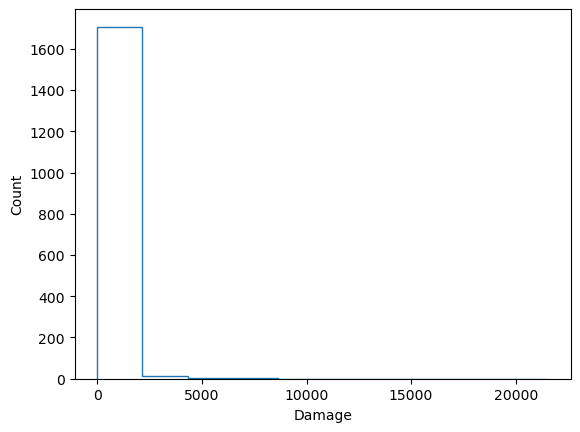

In [35]:
# Plot the dependent variable, 'Damage'

counts, bins = np.histogram(df['Damage'])
plt.stairs(counts, bins)
plt.xlabel('Damage')
plt.ylabel('Count')
plt.show()

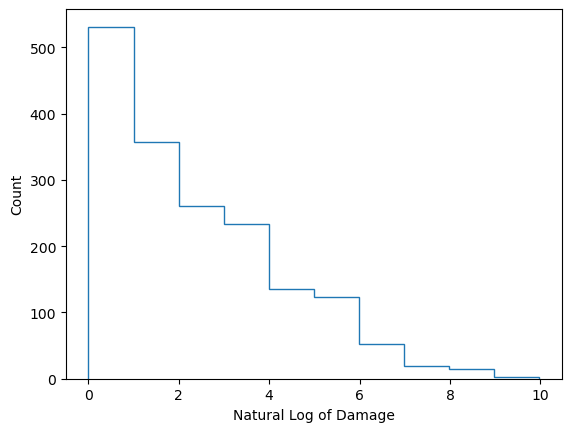

In [36]:
# Plot the dependent variable, 'lnDamage'

counts, bins = np.histogram(df['lnDamage'])
plt.stairs(counts, bins)
plt.xlabel('Natural Log of Damage')
plt.ylabel('Count')
plt.show()

Engineer additional features by combining some of the existing features.

In [37]:
# Factor distance from landfall into the maximum storm windspeed for counties further away from the strongest part of the storm
df['max_wind_speed_div_distance'] = df['Max Wind'] / df['dist_from_landfall']
df['max_wind_speed_div_distance_pressure'] = df['Max Wind'] / df['dist_from_landfall']/df['Max Pressure']
df['wind_speed_closest_div_distance_closest'] = df['Closest_Max_Wind'] / df['distance_from_storm']
df['max_wind_x_pressure'] = df['Max Wind'] * df['Max Pressure']
df['max_wind_x_pressure_div_distance'] = df['Max Wind'] * df['Max Pressure']/ df['dist_from_landfall']
df['closest_wind_x_pressure_div_distance_'] = df['Closest_Max_Wind'] * df['Closest_Max_Pressure'] / df['distance_from_storm']


Identify the quantitative and categorical features and split dataframe into X and y sets.

In [38]:
categories = [
    'category',
    'housing_cluster',
    'econ_cluster'
]
print(categories)

quants = [x for x in df.columns.tolist() if x not in categories]
quants.remove('Damage')
quants.remove('lnDamage')
quants.remove('disasterNumber')

quants

['category', 'housing_cluster', 'econ_cluster']


['Estimate!!HOUSING OCCUPANCY!!Total housing units',
 'Estimate!!HOUSING OCCUPANCY!!Total housing units!!Occupied housing units',
 'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2020 or later',
 'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2010 to 2019',
 'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2000 to 2009',
 'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1990 to 1999',
 'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1980 to 1989',
 'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1970 to 1979',
 'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1960 to 1969',
 'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1950 to 1959',
 'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1940 to 1949',
 'Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1939 or earlier',
 'Max Wind',
 'Max Pressure',
 'dist_from_landfall',
 'Closest_Max_Wind',
 'Closest_Max_Pressure',
 'dista

In [39]:
# Split the dataset into features and target subsets
X = df.drop(['Damage','lnDamage'], axis=1)
y = df['Damage']

In [40]:
print(X.shape)
X.head()

(1730, 28)


,disasterNumber,Estimate!!HOUSING OCCUPANCY!!Total housing units,Estimate!!HOUSING OCCUPANCY!!Total housing units!!Occupied housing units,Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2020 or later,Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2010 to 2019,Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2000 to 2009,Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1990 to 1999,Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1980 to 1989,Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1970 to 1979,Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1960 to 1969,...,distance_from_storm,category,housing_cluster,econ_cluster,max_wind_speed_div_distance,max_wind_speed_div_distance_pressure,wind_speed_closest_div_distance_closest,max_wind_x_pressure,max_wind_x_pressure_div_distance,closest_wind_x_pressure_div_distance_
0,4798,14490.0,12610.0,607,2124,3029,2123,1930,1613,707,...,40.192025,TS,0,0.0,0.917686,0.000938,1.741639,78240,897.497311,1703.322970
1,4798,39773.0,35163.0,450,5102,4043,7717,6694,6517,4276,...,6.349638,TD,0,0.0,0.228661,0.000234,3.937232,78240,223.630252,3952.981291
2,4798,151738.0,136014.0,5397,33277,30493,20487,19722,20481,11002,...,37.310013,TS,0,0.0,1.250476,0.001279,1.876172,78240,1222.965060,1834.896164
3,4798,19330.0,17802.0,1588,4409,4838,2592,1614,1763,1033,...,79.163470,TS,0,0.0,0.717687,0.000734,0.631604,78240,701.898105,624.025196
4,4798,314720.0,302947.0,16692,104372,74473,41857,37753,26000,6351,...,29.248125,TS,0,0.0,1.098007,0.001123,2.393316,78240,1073.851311,2340.662865


Create a preprocessing pipeline to scale the quantitative data and one hot encode the categorical variables.

In [41]:
preprocessor = ColumnTransformer(
    transformers=[
        # ('quant', Normalizer(), quants),
        ('quant', StandardScaler(), quants),
        ('cat', OneHotEncoder(sparse_output=False,
                              handle_unknown='infrequent_if_exist',
                              ).set_output(transform='pandas'), categories)
    ]
).set_output(transform='pandas')
pipe = Pipeline(steps=
                [('preprocessor', preprocessor),
                ])



Run a variety of machine learning models using 10-fold cross validation for selection purposes.

In [42]:
lr_clf = LinearRegression(n_jobs = -1)
br_clf = BayesianRidge()
rf_clf = RandomForestRegressor(random_state=0,
                               n_jobs = -1)
SVR_clf = SVR(kernel='rbf')
gbr_clf = GradientBoostingRegressor(random_state=0)
hgbr_clf = HistGradientBoostingRegressor(random_state=0)
bgr_clf = BaggingRegressor(random_state=0,
                           n_jobs = -1)
mlpr_clf = MLPRegressor(max_iter=1000,
                        random_state=0)
dummy_clf = DummyRegressor()
clf_list = [lr_clf,
            br_clf,
            rf_clf,
            SVR_clf,
            gbr_clf,
            hgbr_clf,
            bgr_clf,
            mlpr_clf,
            dummy_clf,
            ]

X_ = X.drop(['disasterNumber'], axis=1).copy()
X_train_, X_test_, y_train, y_test = train_test_split(X_,
                                                      y,
                                                      test_size=0.2,
                                                      random_state=50,
                                                      )

pipe.fit(X_train_)
X_train = pipe.transform(X_train_)
X_test = pipe.transform(X_test_)

scoring = {
    'r2': 'r2',
    'MAE': 'neg_mean_absolute_error',
    'RMSE': 'neg_root_mean_squared_error',
}

for clf in clf_list:
    cross_val_results = cross_validate(clf,
                                       X_train,
                                       y_train,
                                       cv=10,
                                       scoring=scoring)

    print(f'{clf} Mean R2: {cross_val_results['test_r2'].mean()}, {cross_val_results['test_r2'].std() }')
    print(f'{clf} Mean MAE: {-cross_val_results['test_MAE'].mean()}, {cross_val_results['test_MAE'].std() }')
    print(f'{clf} Mean RMSE: {-cross_val_results['test_RMSE'].mean()}, {cross_val_results['test_RMSE'].std() }')



LinearRegression(n_jobs=-1) Mean R2: -0.5040320095031088, 0.6728080469038763
LinearRegression(n_jobs=-1) Mean MAE: 307.14534065894185, 45.88736632374301
LinearRegression(n_jobs=-1) Mean RMSE: 787.7066413732493, 385.52129724423526
BayesianRidge() Mean R2: -0.3938093353966805, 0.4931783366176896
BayesianRidge() Mean MAE: 282.1236081268893, 48.74035020219574
BayesianRidge() Mean RMSE: 783.0772456474118, 419.9435447024837
RandomForestRegressor(n_jobs=-1, random_state=0) Mean R2: -0.0913286766603496, 0.9751242403777892
RandomForestRegressor(n_jobs=-1, random_state=0) Mean MAE: 159.15212099885306, 48.96387694250783
RandomForestRegressor(n_jobs=-1, random_state=0) Mean RMSE: 644.8554541954885, 398.86337410778725
SVR() Mean R2: -0.028220724562973774, 0.012760067471715823
SVR() Mean MAE: 139.71427330097546, 75.16675546754303
SVR() Mean RMSE: 728.1818265206339, 496.3476358396919
GradientBoostingRegressor(random_state=0) Mean R2: -0.07576430635548659, 0.8834836450185236
GradientBoostingRegressor(

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the 

MLPRegressor(max_iter=1000, random_state=0) Mean R2: -0.12960062358690347, 0.24298416700929237
MLPRegressor(max_iter=1000, random_state=0) Mean MAE: 239.5432529410047, 62.38554528329507
MLPRegressor(max_iter=1000, random_state=0) Mean RMSE: 730.8928103975954, 441.48747469980077
DummyRegressor() Mean R2: -0.009567133150187822, 0.015595024122563875
DummyRegressor() Mean MAE: 226.64229192409272, 66.02999775895594
DummyRegressor() Mean RMSE: 721.5631135849302, 493.5247919485189


/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


The results are very disappointing. This could be caused in part to the high number of low/no damage entries, which is primarily tied to storm strength. This is measured by the feature 'category'.

Stratifying on storm category as we want to have an better spread of damages in each fold for better training results.

We will also try taking the natural log of the target variable to correct for the skewness noticed earlier in the notebook.

#### Note - the use of StandardScaler instead of Normalizer for the quantitative features changed the outcomes of this test after completion of the notebook to give slightly better metric scores to HistGradientBoostingRegressor than RandomForestRegressor. In response, hyperparameter tuning and sensitivity testing of HistGradientBoostingRegressor was added but the final results are calculated using RandomForestRegressor.

In [43]:
groups = X_['category'].astype(str)

X_train, X_test, y_train, y_test, groups_train = transformed_train_test_split(X_,
                                                                y,
                                                                0.2,
                                                                50,
                                                                pipe,
                                                                groups)


skfold = StratifiedKFold(n_splits=10,
                         shuffle=True,
                         random_state=0)

for clf in clf_list:
    cross_val_results = cross_validate(clf,
                                        X_train,
                                        y_train,
                                        cv=skfold.split(X_train, groups_train),
                                        scoring=scoring,
                                        )

    print(f'{clf} Mean R2: {cross_val_results['test_r2'].mean()}, {cross_val_results['test_r2'].std() }')
    print(f'{clf} Mean MAE: {-cross_val_results['test_MAE'].mean()}, {cross_val_results['test_MAE'].std() }')
    print(f'{clf} Mean RMSE: {-cross_val_results['test_RMSE'].mean()} ,{cross_val_results['test_RMSE'].std() }')


LinearRegression(n_jobs=-1) Mean R2: 0.3583500343140934, 0.09624531366478017
LinearRegression(n_jobs=-1) Mean MAE: 1.2716168893166062, 0.11699805372987318
LinearRegression(n_jobs=-1) Mean RMSE: 1.6255106260953707 ,0.16934557485108334
BayesianRidge() Mean R2: 0.3618881634981819, 0.0839381671300563
BayesianRidge() Mean MAE: 1.281295992433011, 0.11220522254060254
BayesianRidge() Mean RMSE: 1.620687961234852 ,0.14648132534062466
RandomForestRegressor(n_jobs=-1, random_state=0) Mean R2: 0.5860168129919938, 0.07840113397362539
RandomForestRegressor(n_jobs=-1, random_state=0) Mean MAE: 1.0075185184379731, 0.10035401091758868
RandomForestRegressor(n_jobs=-1, random_state=0) Mean RMSE: 1.301438040105649 ,0.13447518563357258
SVR() Mean R2: 0.46040106717799445, 0.08853506980584812
SVR() Mean MAE: 1.1308664098162802, 0.09230832903003731
SVR() Mean RMSE: 1.4879443728811743 ,0.15208516974553163
GradientBoostingRegressor(random_state=0) Mean R2: 0.5664526254360809, 0.058010869436387176
GradientBoosti

Much more encouraging results. HistGradientBoostingRegressor and Random Forest Regressor slightly edge out the others. We will progress through our Supervised Learning exploration with these as our primary models, along with MLPRegressor as .

Our target has many values at or near zero, so MAPE is not a good choice for a scoring metric in this situation. We will instead use Mean Absolute Error (MAE) as the scoring metric for our intial hyperparameter search using RandomSearchCV. This will include a stratified 10-fold cross validation.

In [50]:
# Set the parameter values for random selection
param_dist = {
    "max_depth": stats.randint(2, 30),
    "n_estimators": stats.randint(20, 200),
    "max_features": stats.uniform(.25, 1),
    "max_samples": stats.uniform(.2, .99),
}

clf = RandomForestRegressor(random_state=0,
                            n_jobs = -1)

# Conduct 100 iterations
n_iter_search = 100
random_search_rfr = RandomizedSearchCV(
    clf, 
    param_distributions=param_dist, 
    n_iter=n_iter_search, 
    random_state=0,
    cv = skfold.split(X_train, groups_train),
    scoring='neg_mean_absolute_error',
    return_train_score=True,
    n_jobs=-1
)

random_search_rfr.fit(X_train, y_train)

print(random_search_rfr.best_params_)
best_model_rfr = random_search_rfr.best_estimator_
best_model_rfr.fit(X_train, y_train)

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
360 fits failed out of a total of 1000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
    ~~~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "/U

{'max_depth': 22, 'max_features': np.float64(0.5518308759275166), 'max_samples': np.float64(0.967467579691945), 'n_estimators': 131}


RandomForestRegressor(max_depth=22, max_features=np.float64(0.5518308759275166),
                      max_samples=np.float64(0.967467579691945),
                      n_estimators=131, n_jobs=-1, random_state=0)

Review the scoring outcomes

In [51]:
training_scores = random_search_rfr.cv_results_
mean_mae = -np.nanmean(training_scores['mean_test_score'])
std_mae = np.nanstd(training_scores['mean_test_score'])
print(f'Mean MAE Score: {mean_mae, std_mae}')


Mean MAE Score: (np.float64(1.0745827387321287), np.float64(0.08543849618347193))


In [47]:
# Set the parameter values for random selection
param_dist = {
    "max_bins": stats.randint(2, 200),
    "max_iter": stats.randint(20, 300),
    "learning_rate": stats.uniform(.01, .3),
    "max_features": stats.uniform(.2, .99),
}

clf = HistGradientBoostingRegressor(random_state=0,
                            )

# Conduct 100 iterations
n_iter_search = 100
random_search_hgbr = RandomizedSearchCV(
    clf, 
    param_distributions=param_dist, 
    n_iter=n_iter_search, 
    random_state=0,
    cv = skfold.split(X_train, groups_train),
    scoring='neg_mean_absolute_error',
    return_train_score=True,
    n_jobs=-1
)

random_search_hgbr.fit(X_train, y_train)

print(random_search_hgbr.best_params_)
best_model_hgbr = random_search_hgbr.best_estimator_
best_model_hgbr.fit(X_train, y_train)

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
160 fits failed out of a total of 1000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
    ~~~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "/U

{'learning_rate': np.float64(0.03591309411119237), 'max_bins': 86, 'max_features': np.float64(0.8900272693077376), 'max_iter': 243}


HistGradientBoostingRegressor(learning_rate=np.float64(0.03591309411119237),
                              max_bins=86,
                              max_features=np.float64(0.8900272693077376),
                              max_iter=243, random_state=0)

In [48]:
training_scores = random_search_hgbr.cv_results_
mean_mae = -np.nanmean(training_scores['mean_test_score'])
std_mae = np.nanstd(training_scores['mean_test_score'])
print(f'Mean MAE Score: {mean_mae, std_mae}')


Mean MAE Score: (np.float64(1.0380482893128522), np.float64(0.07651625194584712))


In [85]:
# Set the parameter values for random selection
param_dist = {
    "hidden_layer_sizes": stats.randint(50, 200),
    "max_iter": stats.randint(500, 2000),
    "learning_rate_init": stats.uniform(.0001, .3),
    "activation": ['relu', 'identity', 'logistic', 'tanh'],
}

clf = MLPRegressor(random_state=0,
                            )

# Conduct 100 iterations
n_iter_search = 100
random_search_MLP = RandomizedSearchCV(
    clf, 
    param_distributions=param_dist, 
    n_iter=n_iter_search, 
    random_state=0,
    cv = skfold.split(X_train, groups_train),
    scoring='neg_mean_absolute_error',
    return_train_score=True,
    n_jobs=-1
)

random_search_MLP.fit(X_train, y_train)

print(random_search_MLP.best_params_)
best_model_mlp = random_search_MLP.best_estimator_
best_model_mlp.fit(X_train, y_train)

{'activation': 'logistic', 'hidden_layer_sizes': 165, 'learning_rate_init': np.float64(0.006132263856248066), 'max_iter': 988}


MLPRegressor(activation='logistic', hidden_layer_sizes=165,
             learning_rate_init=np.float64(0.006132263856248066), max_iter=988,
             random_state=0)

In [86]:
training_scores = random_search_MLP.cv_results_
mean_mae = -np.nanmean(training_scores['mean_test_score'])
std_mae = np.nanstd(training_scores['mean_test_score'])
print(f'Mean MAE Score: {mean_mae, std_mae}')


Mean MAE Score: (np.float64(1.2394677013721436), np.float64(0.09659713678339009))


The Multi-Layer Perceptron does not perform as well as the other models.

Compare the outcomes of our hyperparameter search results to our Random Forest and HistGradientBoosting Regressor models.

In [93]:
clf_list = [
    rf_clf,
    best_model_rfr,
    hgbr_clf,
    best_model_hgbr,
    mlpr_clf,
    best_model_mlp
]

for clf in clf_list:
    cross_val_results = cross_validate(clf,
                                        X_train,
                                        y_train,
                                        cv=skfold.split(X_train, groups_train),
                                        scoring=scoring,
                                        )

    print(f'{clf} Mean R2: {cross_val_results['test_r2'].mean()}, {cross_val_results['test_r2'].std() }')
    print(f'{clf} Mean MAE: {-cross_val_results['test_MAE'].mean()}, {cross_val_results['test_MAE'].std() }')
    print(f'{clf} Mean RMSE: {-cross_val_results['test_RMSE'].mean()} ,{cross_val_results['test_RMSE'].std() }')


RandomForestRegressor(n_jobs=-1, random_state=0) Mean R2: 0.5860168129919938, 0.07840113397362539
RandomForestRegressor(n_jobs=-1, random_state=0) Mean MAE: 1.0075185184379731, 0.10035401091758868
RandomForestRegressor(n_jobs=-1, random_state=0) Mean RMSE: 1.301438040105649 ,0.13447518563357258
RandomForestRegressor(max_depth=22, max_features=np.float64(0.5518308759275166),
                      max_samples=np.float64(0.967467579691945),
                      n_estimators=131, n_jobs=-1, random_state=0) Mean R2: 0.5855192189522429, 0.07347730843266176
RandomForestRegressor(max_depth=22, max_features=np.float64(0.5518308759275166),
                      max_samples=np.float64(0.967467579691945),
                      n_estimators=131, n_jobs=-1, random_state=0) Mean MAE: 1.004514787266295, 0.09468145726680527
RandomForestRegressor(max_depth=22, max_features=np.float64(0.5518308759275166),
                      max_samples=np.float64(0.967467579691945),
                      n_estimators

Write the values for max_features and n_estimators to variables for our hypersensitivty analysis starting points

In [ ]:
max_features = random_search_rfr.best_params_['max_features']
num_estimators = random_search_rfr.best_params_['n_estimators']


Hyperparameter sensitivity analysis

Max depth, max features, and number of estimators are the most likely to impact performance the most.

In [631]:
depths = list(range(1,31,1))
results = []
for depth in depths:
    clf = RandomForestRegressor(max_depth=depth, 
                                max_features=max_features,
                                n_estimators=num_estimators,
                                random_state=0,
                                n_jobs = -1,
                                )
    scores = cross_val_score(clf,
                             X_train,
                             y_train,
                             cv = skfold.split(X_train, groups_train),
                             scoring = 'neg_mean_absolute_error',
                             n_jobs = -1,
                             )
    mean_mae = -np.mean(scores)
    std_mae = np.std(scores)
    results.append((depth, mean_mae, std_mae))

df_results = pd.DataFrame(results, columns=['model_depth', 'mean_mae', 'std_mae'])


Plot the results of the max_depth exploration.

<Figure size 800x500 with 0 Axes>

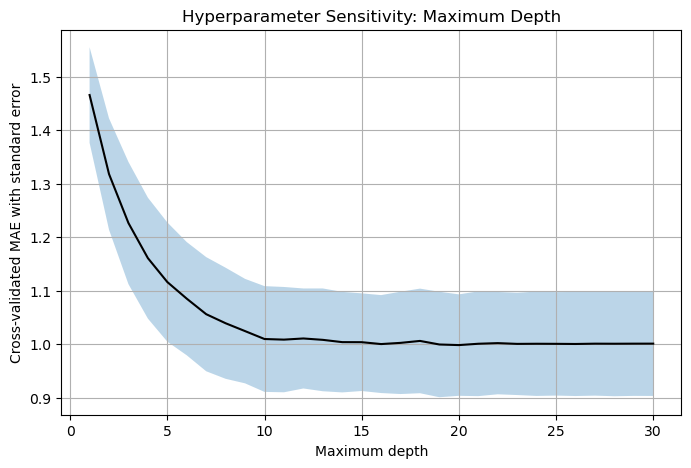

In [632]:
plt.figure(figsize=(8, 5))
plt.figure(figsize=(8, 5))
plt.plot(df_results['model_depth'],
         df_results['mean_mae'],
         color='k')
plt.fill_between(df_results['model_depth'], 
                 df_results['mean_mae']-df_results['std_mae'].abs(),
                 df_results['mean_mae']+df_results['std_mae'].abs(),
                 alpha=0.3)
plt.xlabel('Maximum depth')
plt.ylabel('Cross-validated MAE with standard error')
plt.title('Hyperparameter Sensitivity: Maximum Depth')
plt.grid(True)
plt.show()

In [633]:
df_results[df_results['model_depth']>=15]

,model_depth,mean_mae,std_mae
14,15,1.003735,0.091286
15,16,1.000219,0.091557
16,17,1.002456,0.095650
17,18,1.006096,0.097770
18,19,0.999419,0.098570
19,20,0.998318,0.094841
20,21,1.000803,0.097934
21,22,1.001981,0.095658
22,23,1.000563,0.095658
23,24,1.000789,0.097541


Repeat for number of estimators

In [634]:
estimators = list(range(10,200,5))
results = []
for estimator in estimators:
    clf = RandomForestRegressor(max_depth = 15, 
                                max_features = max_features,
                                n_estimators = estimator, 
                                random_state = 0,
                                n_jobs = -1)
    scores = cross_val_score(clf,
                             X_train,
                             y_train,
                             cv = skfold.split(X_train, groups_train),
                             scoring = 'neg_mean_absolute_error',
                             n_jobs=-1
                             )
    mean_mae = -np.mean(scores)
    std_mae = np.std(scores)
    results.append((estimator, mean_mae, std_mae))

df_results2 = pd.DataFrame(results, columns=['n_estimators', 'mean_mae', 'std_mae'])


<Figure size 800x500 with 0 Axes>

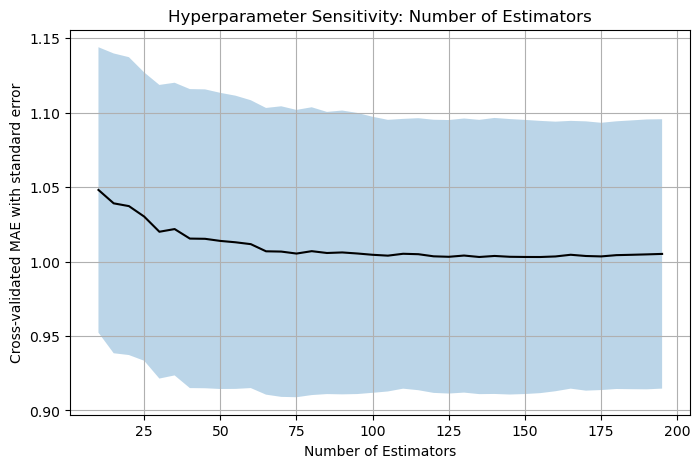

In [635]:
plt.figure(figsize=(8, 5))
plt.figure(figsize=(8, 5))
plt.plot(df_results2['n_estimators'],
         df_results2['mean_mae'],
         color='k')
plt.fill_between(df_results2['n_estimators'], 
                 df_results2['mean_mae']-df_results2['std_mae'].abs(),
                 df_results2['mean_mae']+df_results2['std_mae'].abs(),
                 alpha=0.3)
plt.xlabel('Number of Estimators')
plt.ylabel('Cross-validated MAE with standard error')
plt.title('Hyperparameter Sensitivity: Number of Estimators')
plt.grid(True)
plt.show()

Repeat for max_features.

In [636]:
features = list(range(1,X_train.shape[1]+1,1))
results = []
for feature in features:
    clf = RandomForestRegressor(max_depth=15, 
                                max_features=feature,
                                n_estimators=70,
                                random_state=0,
                                n_jobs = -1,
                                )
    scores = cross_val_score(clf,
                             X_train,
                             y_train,
                             cv = skfold.split(X_train, groups_train),
                             scoring = 'neg_mean_absolute_error',
                             n_jobs = -1,
                             )
    mean_mae = -np.mean(scores)
    std_mae = np.std(scores)
    results.append((feature, mean_mae, std_mae))

df_results3 = pd.DataFrame(results, columns=['model_features', 'mean_mae', 'std_mae'])


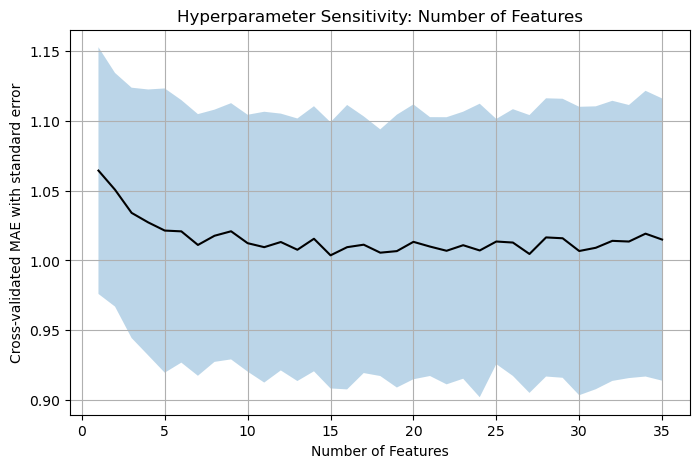

In [637]:
plt.figure(figsize=(8, 5))
plt.plot(df_results3['model_features'],
         df_results3['mean_mae'],
         color='k')
plt.fill_between(df_results3['model_features'], 
                 df_results3['mean_mae']-df_results3['std_mae'].abs(),
                 df_results3['mean_mae']+df_results3['std_mae'].abs(),
                 alpha=0.3)
plt.xlabel('Number of Features')
plt.ylabel('Cross-validated MAE with standard error')
plt.title('Hyperparameter Sensitivity: Number of Features')
plt.grid(True)
plt.show()

Perform a dual hypersensitivity analysis for max_depth and max_features.

In [638]:
features = list(range(1,21,1))
depths = list(range(1,31,1))

results = []
for feature in features:
    for depth in depths:
        clf = RandomForestRegressor(max_depth=depth, 
                                    max_features=feature,
                                    n_estimators=50,
                                    random_state=0,
                                    n_jobs = -1,
                                    )
        scores = cross_val_score(clf,
                                X_train,
                                y_train,
                                cv = skfold.split(X_train, groups_train),
                                scoring = 'neg_mean_absolute_error',
                                n_jobs = -1,
                                )
        mean_mae = -np.mean(scores)
        std_mae = np.std(scores)
        results.append((feature, depth, mean_mae, std_mae))

df_results4 = pd.DataFrame(results, 
                           columns=['model_features', 'model_depth', 'mean_mae', 'std_mae'])


In [639]:
# Save the results for later use as the analysis takes an hour to run
df_results4.to_csv('df_results4.csv')

In [640]:
Z_grid = df_results4.pivot_table(index='model_depth',
                                 columns='model_features',
                                 values='mean_mae',
                                 ).sort_index(ascending=True)
x = Z_grid.columns.values
y__ = Z_grid.index.values
z = Z_grid.values

fig = go.Figure(data=[go.Surface(z=z, x=x, y=y__)])
fig.update_layout(title=dict(text='Hyperparameter Sensitivity Analysis'), 
                #   autosize=True, 
                  width=600, 
                  height=400,
                  margin=dict(l=20, r=20, b=50, t=50),
                  scene=dict(
                      xaxis_title = 'Features',
                      yaxis_title = 'Depth',
                      zaxis_title = 'Mean MAE'
                  )
                  )
fig.show()

Find the lowest mean MAE value

In [641]:
df_results4.sort_values(by='mean_mae', ascending=True).head()

,model_features,model_depth,mean_mae,std_mae
468,16,19,1.002882,0.088753
438,15,19,1.003614,0.086433
442,15,23,1.003751,0.087462
440,15,21,1.003846,0.091121
466,16,17,1.003978,0.093279


Create new best model and view R2 and MAE scores on test set.

In [80]:
new_best_model_rfr = RandomForestRegressor(max_depth=23, 
                                    max_features=18,
                                    n_estimators=50,
                                    random_state=0,
                                    n_jobs = -1,
                                    )
new_best_model_rfr.fit(X_train, y_train)
new_y_pred = new_best_model_rfr.predict(X_test)
print(r2_score(y_test, new_y_pred))
print(mean_absolute_error(y_test, new_y_pred))

0.5322599964282302
0.9809428044484592


Hyperparameter sensitivity analysis for HistGradientBoostingRegressor.
Start with learning rate then maximum iterations, maximum bins, and maximum features.

In [ ]:
rates = np.arange(.01, .501, .02)
results = []
for rate in rates:
    clf = HistGradientBoostingRegressor(
        learning_rate=rate,
        max_bins=86,
        max_features=np.float64(0.8900272693077376),
        max_iter=243, 
        random_state=0)
    scores = cross_val_score(clf,
                             X_train,
                             y_train,
                             cv = skfold.split(X_train, groups_train),
                             scoring = 'neg_mean_absolute_error',
                             n_jobs = -1,
                             )
    mean_mae = -np.mean(scores)
    std_mae = np.std(scores)
    results.append((rate, mean_mae, std_mae))

df_results_hgbr = pd.DataFrame(results, columns=['model_learning_rate', 'mean_mae', 'std_mae'])


<Figure size 800x500 with 0 Axes>

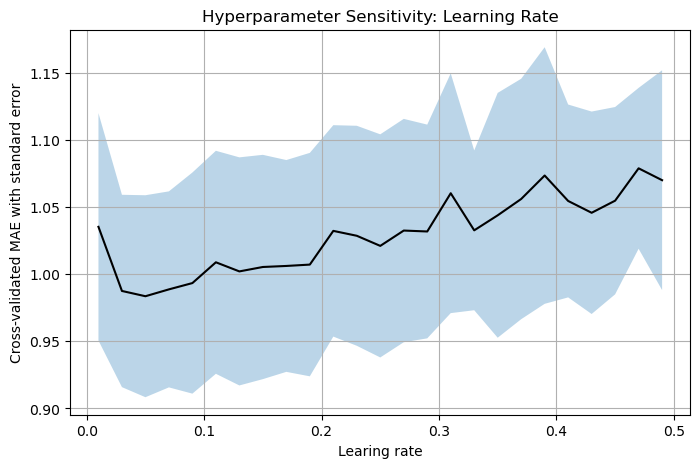

In [ ]:
plt.figure(figsize=(8, 5))
plt.figure(figsize=(8, 5))
plt.plot(df_results_hgbr['model_learning_rate'],
         df_results_hgbr['mean_mae'],
         color='k')
plt.fill_between(df_results_hgbr['model_learning_rate'], 
                 df_results_hgbr['mean_mae']-df_results_hgbr['std_mae'].abs(),
                 df_results_hgbr['mean_mae']+df_results_hgbr['std_mae'].abs(),
                 alpha=0.3)
plt.xlabel('Learning rate')
plt.ylabel('Cross-validated MAE with standard error')
plt.title('Hyperparameter Sensitivity: Learning Rate')
plt.grid(True)
plt.show()

In [ ]:
df_results_hgbr.sort_values(by='mean_mae',
                       ascending=True)

,model_learning_rate,mean_mae,std_mae
2,0.05,0.983626,0.075278
1,0.03,0.987557,0.071686
3,0.07,0.988738,0.073055
4,0.09,0.993434,0.082416
6,0.13,1.002133,0.085013
7,0.15,1.005427,0.083605
8,0.17,1.006195,0.078939
9,0.19,1.007206,0.083282
5,0.11,1.008924,0.083118
12,0.25,1.021150,0.083165


In [60]:
bins = np.arange(2, 203, 5)
results = []
for bin in bins:
    clf = HistGradientBoostingRegressor(
        learning_rate=0.05,
        max_bins=bin,
        max_features=np.float64(0.8900272693077376),
        max_iter=243, 
        random_state=0)
    scores = cross_val_score(clf,
                             X_train,
                             y_train,
                             cv = skfold.split(X_train, groups_train),
                             scoring = 'neg_mean_absolute_error',
                             n_jobs = -1,
                             )
    mean_mae = -np.mean(scores)
    std_mae = np.std(scores)
    results.append((bin, mean_mae, std_mae))

df_results_hgbr2 = pd.DataFrame(results, columns=['model_max_bins', 'mean_mae', 'std_mae'])


<Figure size 800x500 with 0 Axes>

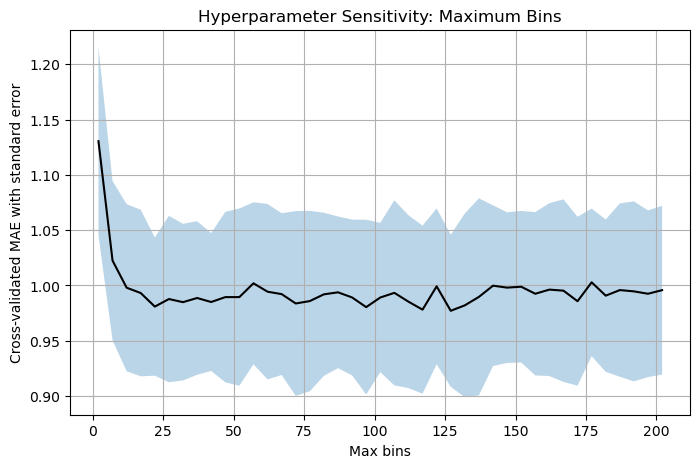

In [61]:
plt.figure(figsize=(8, 5))
plt.figure(figsize=(8, 5))
plt.plot(df_results_hgbr2['model_max_bins'],
         df_results_hgbr2['mean_mae'],
         color='k')
plt.fill_between(df_results_hgbr2['model_max_bins'], 
                 df_results_hgbr2['mean_mae']-df_results_hgbr2['std_mae'].abs(),
                 df_results_hgbr2['mean_mae']+df_results_hgbr2['std_mae'].abs(),
                 alpha=0.3)
plt.xlabel('Max bins')
plt.ylabel('Cross-validated MAE with standard error')
plt.title('Hyperparameter Sensitivity: Maximum Bins')
plt.grid(True)
plt.show()

In [62]:
df_results_hgbr2.sort_values(by='mean_mae',
                       ascending=True)

,model_max_bins,mean_mae,std_mae
25,127,0.977052,0.068741
23,117,0.978081,0.075989
19,97,0.980353,0.079034
4,22,0.980844,0.062478
26,132,0.981970,0.083076
14,72,0.983650,0.083531
6,32,0.984853,0.070832
8,42,0.984990,0.062315
22,112,0.985287,0.078157
34,172,0.985719,0.076359


In [66]:
iters = np.arange(2, 303, 5)
results = []
for iter in iters:
    clf = HistGradientBoostingRegressor(
        learning_rate=0.05,
        max_bins=127,
        max_features=np.float64(0.8900272693077376),
        max_iter=iter, 
        random_state=0)
    scores = cross_val_score(clf,
                             X_train,
                             y_train,
                             cv = skfold.split(X_train, groups_train),
                             scoring = 'neg_mean_absolute_error',
                             n_jobs = -1,
                             )
    mean_mae = -np.mean(scores)
    std_mae = np.std(scores)
    results.append((iter, mean_mae, std_mae))

df_results_hgbr3 = pd.DataFrame(results, columns=['model_max_iter', 'mean_mae', 'std_mae'])


<Figure size 800x500 with 0 Axes>

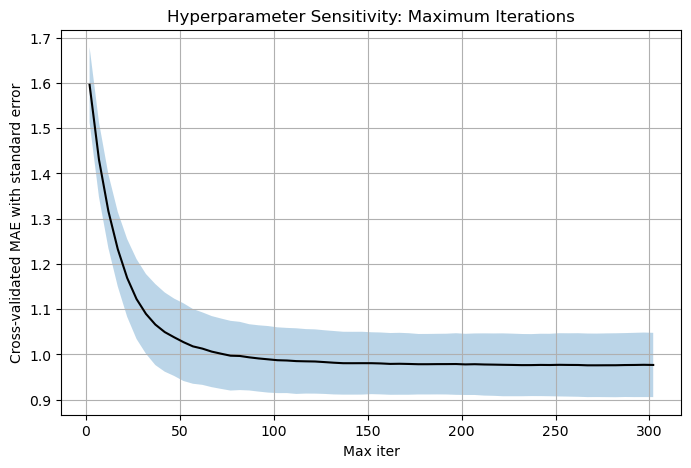

In [67]:
plt.figure(figsize=(8, 5))
plt.figure(figsize=(8, 5))
plt.plot(df_results_hgbr3['model_max_iter'],
         df_results_hgbr3['mean_mae'],
         color='k')
plt.fill_between(df_results_hgbr3['model_max_iter'], 
                 df_results_hgbr3['mean_mae']-df_results_hgbr3['std_mae'].abs(),
                 df_results_hgbr3['mean_mae']+df_results_hgbr3['std_mae'].abs(),
                 alpha=0.3)
plt.xlabel('Max iter')
plt.ylabel('Cross-validated MAE with standard error')
plt.title('Hyperparameter Sensitivity: Maximum Iterations')
plt.grid(True)
plt.show()

In [68]:
df_results_hgbr3.sort_values(by='mean_mae',
                       ascending=True)

,model_max_iter,mean_mae,std_mae
53,267,0.976080,0.070239
54,272,0.976083,0.070114
55,277,0.976190,0.070427
56,282,0.976228,0.070644
46,232,0.976517,0.068763
...,...,...,...
4,22,1.169128,0.085903
3,17,1.232759,0.082439
2,12,1.316730,0.081540
1,7,1.430289,0.082694


In [69]:
features = np.arange(.2, 1.01, .05)
results = []
for feature in features:
    clf = HistGradientBoostingRegressor(
        learning_rate=0.05,
        max_bins=127,
        max_features=feature,
        max_iter=232, 
        random_state=0)
    scores = cross_val_score(clf,
                             X_train,
                             y_train,
                             cv = skfold.split(X_train, groups_train),
                             scoring = 'neg_mean_absolute_error',
                             n_jobs = -1,
                             )
    mean_mae = -np.mean(scores)
    std_mae = np.std(scores)
    results.append((feature, mean_mae, std_mae))

df_results_hgbr4 = pd.DataFrame(results, columns=['model_max_features', 'mean_mae', 'std_mae'])


<Figure size 800x500 with 0 Axes>

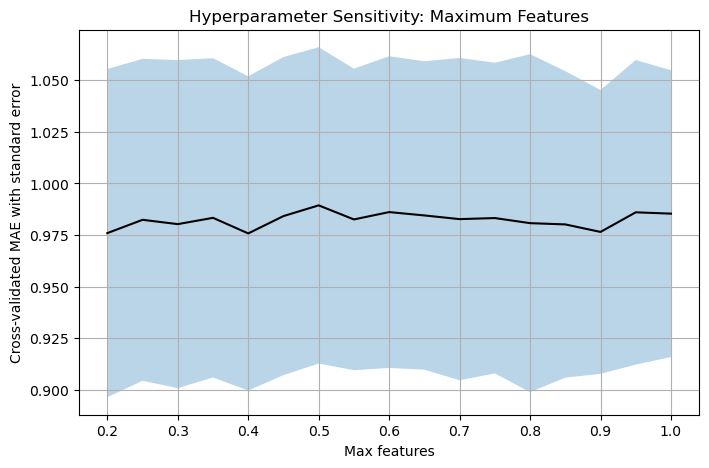

In [70]:
plt.figure(figsize=(8, 5))
plt.figure(figsize=(8, 5))
plt.plot(df_results_hgbr4['model_max_features'],
         df_results_hgbr4['mean_mae'],
         color='k')
plt.fill_between(df_results_hgbr4['model_max_features'], 
                 df_results_hgbr4['mean_mae']-df_results_hgbr4['std_mae'].abs(),
                 df_results_hgbr4['mean_mae']+df_results_hgbr4['std_mae'].abs(),
                 alpha=0.3)
plt.xlabel('Max features')
plt.ylabel('Cross-validated MAE with standard error')
plt.title('Hyperparameter Sensitivity: Maximum Features')
plt.grid(True)
plt.show()

Perform dual hypersensitivity analysis on maximum iterations and learning rate.

In [74]:
iters = np.arange(2, 303, 5)
rates = np.arange(.01, .1, .005)

results = []
for iter in iters:
    for rate in rates:
        clf = HistGradientBoostingRegressor(
            learning_rate=rate,
            max_bins=232,
            max_features=0.4,
            max_iter=iter, 
            random_state=0)
        scores = cross_val_score(clf,
                                X_train,
                                y_train,
                                cv = skfold.split(X_train, groups_train),
                                scoring = 'neg_mean_absolute_error',
                                n_jobs = -1,
                                )
        mean_mae = -np.mean(scores)
        std_mae = np.std(scores)
        results.append((iter, rate, mean_mae, std_mae))

df_results_hgbr5 = pd.DataFrame(results, 
                           columns=['model_max_iter', 'model_learning_rate', 'mean_mae', 'std_mae'])


In [76]:
Z_grid2 = df_results_hgbr5.pivot_table(index='model_max_iter',
                                 columns='model_learning_rate',
                                 values='mean_mae',
                                 ).sort_index(ascending=True)
x2 = Z_grid2.columns.values
y__2 = Z_grid2.index.values
z2 = Z_grid2.values

fig = go.Figure(data=[go.Surface(z=z2, x=x2, y=y__2)])
fig.update_layout(title=dict(text='Hyperparameter Sensitivity Analysis'), 
                #   autosize=True, 
                  width=600, 
                  height=400,
                  margin=dict(l=20, r=20, b=50, t=50),
                  scene=dict(
                      xaxis_title = 'Learning Rate',
                      yaxis_title = 'Max Iterations',
                      zaxis_title = 'Mean MAE'
                  )
                  )
fig.show()

In [71]:
new_best_model_hgbr = HistGradientBoostingRegressor(
    learning_rate=0.05,
    max_bins=127,
    max_features=0.4,
    max_iter=232, 
    random_state=0)
new_best_model_hgbr.fit(X_train, y_train)
new_y_pred = new_best_model_hgbr.predict(X_test)
print(r2_score(y_test, new_y_pred))
print(mean_absolute_error(y_test, new_y_pred))

0.5647388006037124
0.9296914758486785


HistGradientBoostingRegressor does not offer feature_importance_. Due to this, we will finish the notebook with the best RandomForestRegressor model instead, which offers similar performance.

View feature importances for new best model.

/var/folders/15/mh2mgzhn1191h4zq_5d03wfc0000gn/T/ipykernel_8418/518344820.py:9: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.



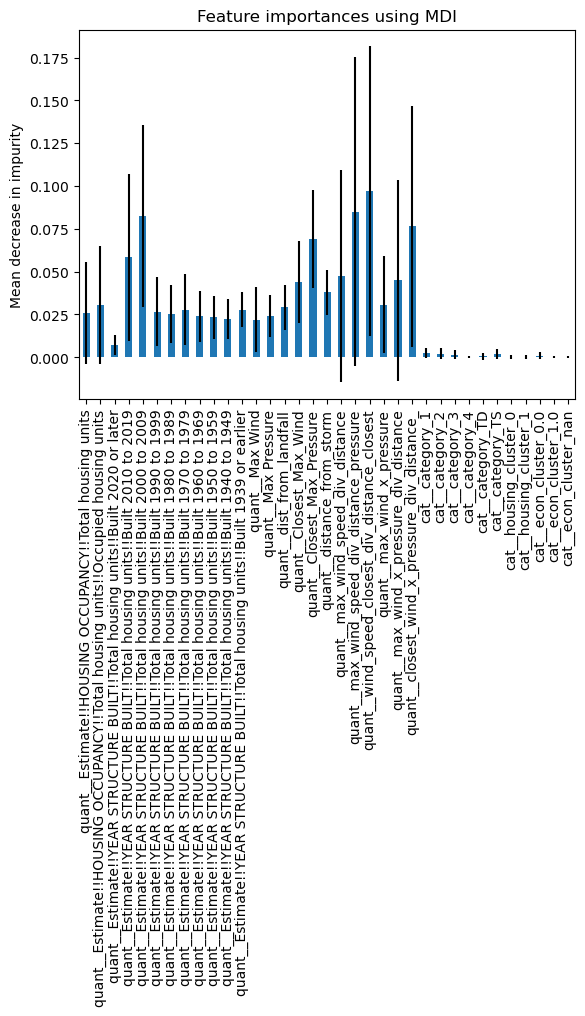

In [81]:
importances = new_best_model_rfr.feature_importances_
feature_names = [i for i in X_train.columns]
std = np.std([tree.feature_importances_ for tree in new_best_model_rfr.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

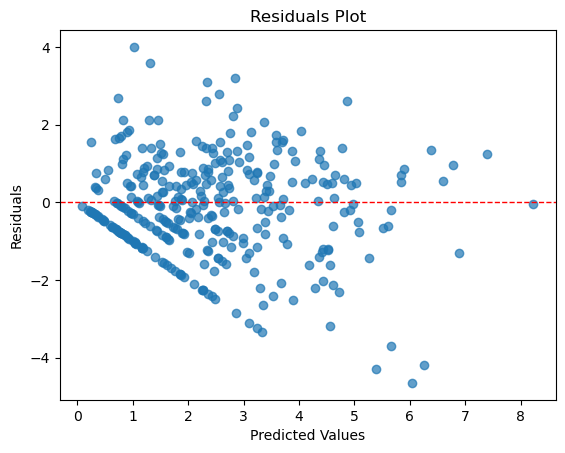

In [82]:
y_pred = new_best_model_rfr.predict(X_test)
residuals = y_test - y_pred

# Plot residuals
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--', linewidth=1)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals Plot")
plt.show()

Feature Importance Ranking:
 Index(['quant__wind_speed_closest_div_distance_closest',
       'quant__max_wind_speed_div_distance_pressure',
       'quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2000 to 2009',
       'quant__closest_wind_x_pressure_div_distance_',
       'quant__Closest_Max_Pressure',
       'quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2010 to 2019',
       'quant__max_wind_speed_div_distance',
       'quant__max_wind_x_pressure_div_distance', 'quant__Closest_Max_Wind',
       'quant__distance_from_storm', 'quant__max_wind_x_pressure',
       'quant__Estimate!!HOUSING OCCUPANCY!!Total housing units!!Occupied housing units',
       'quant__dist_from_landfall',
       'quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1939 or earlier',
       'quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1970 to 1979',
       'quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1990 to 1999',
    

/var/folders/15/mh2mgzhn1191h4zq_5d03wfc0000gn/T/ipykernel_8418/3350051111.py:21: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.

/var/folders/15/mh2mgzhn1191h4zq_5d03wfc0000gn/T/ipykernel_8418/3350051111.py:27: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.



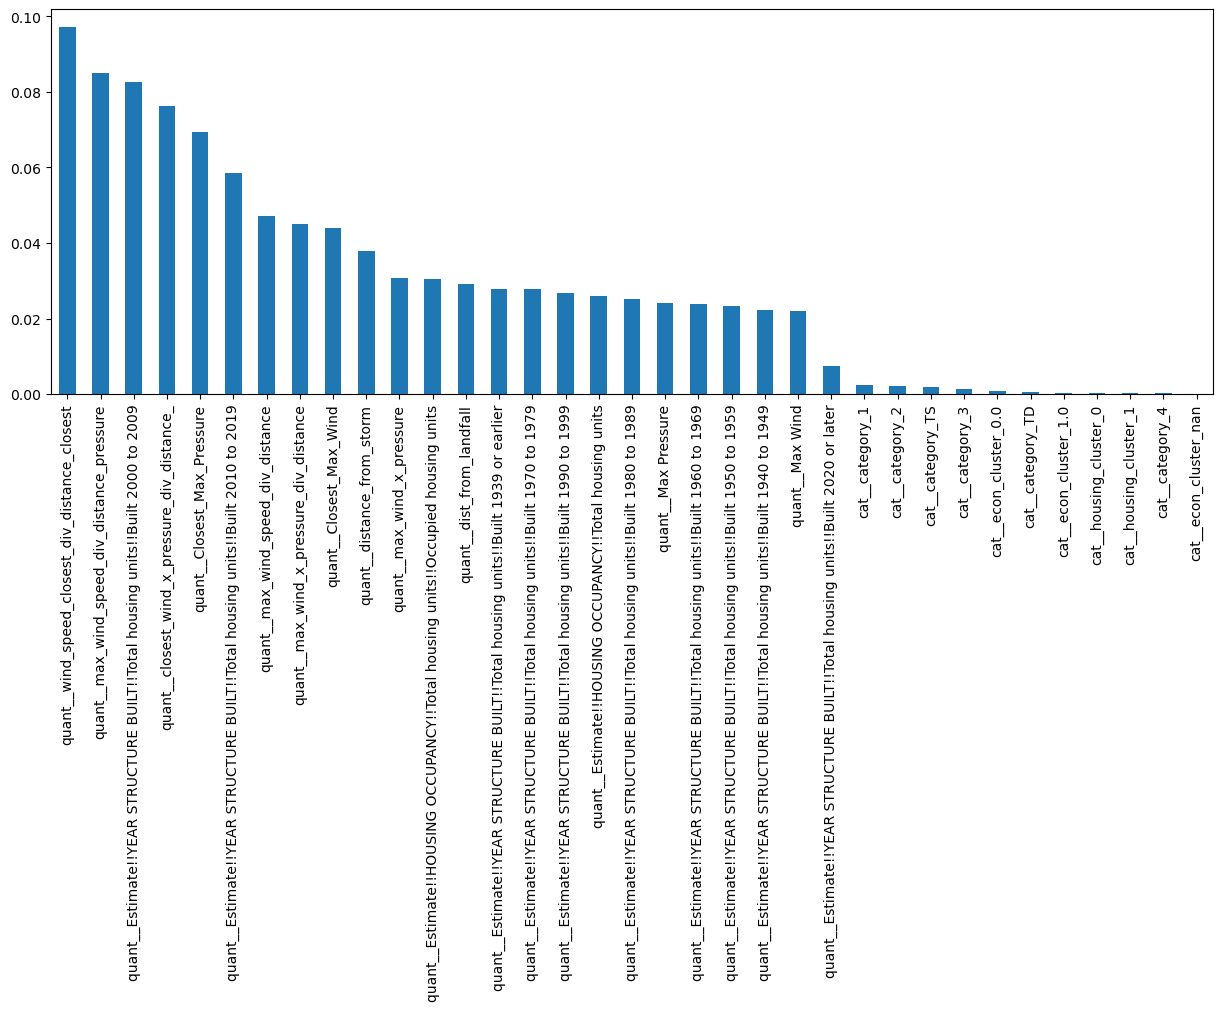

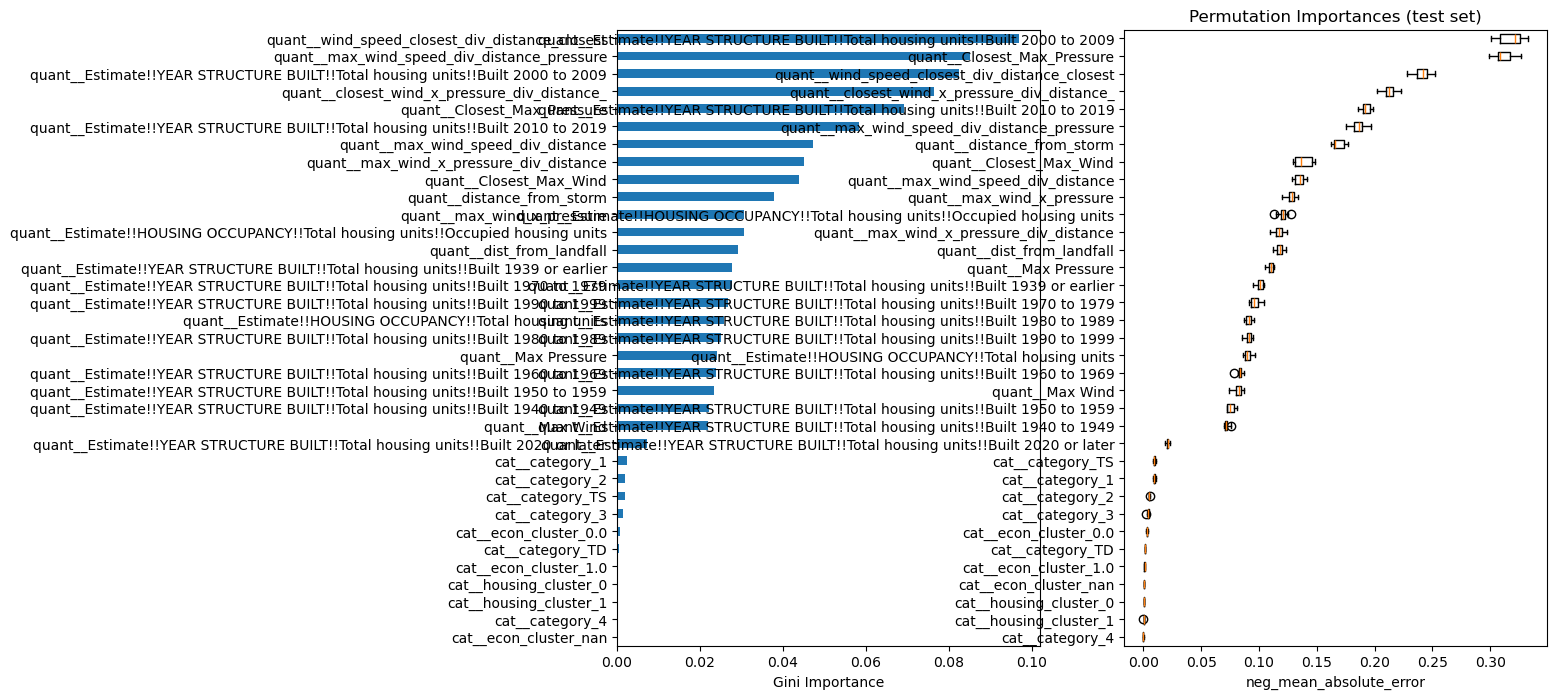

/var/folders/15/mh2mgzhn1191h4zq_5d03wfc0000gn/T/ipykernel_8418/3350051111.py:62: UserWarning:

Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations

/var/folders/15/mh2mgzhn1191h4zq_5d03wfc0000gn/T/ipykernel_8418/3350051111.py:21: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.

/var/folders/15/mh2mgzhn1191h4zq_5d03wfc0000gn/T/ipykernel_8418/3350051111.py:27: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.



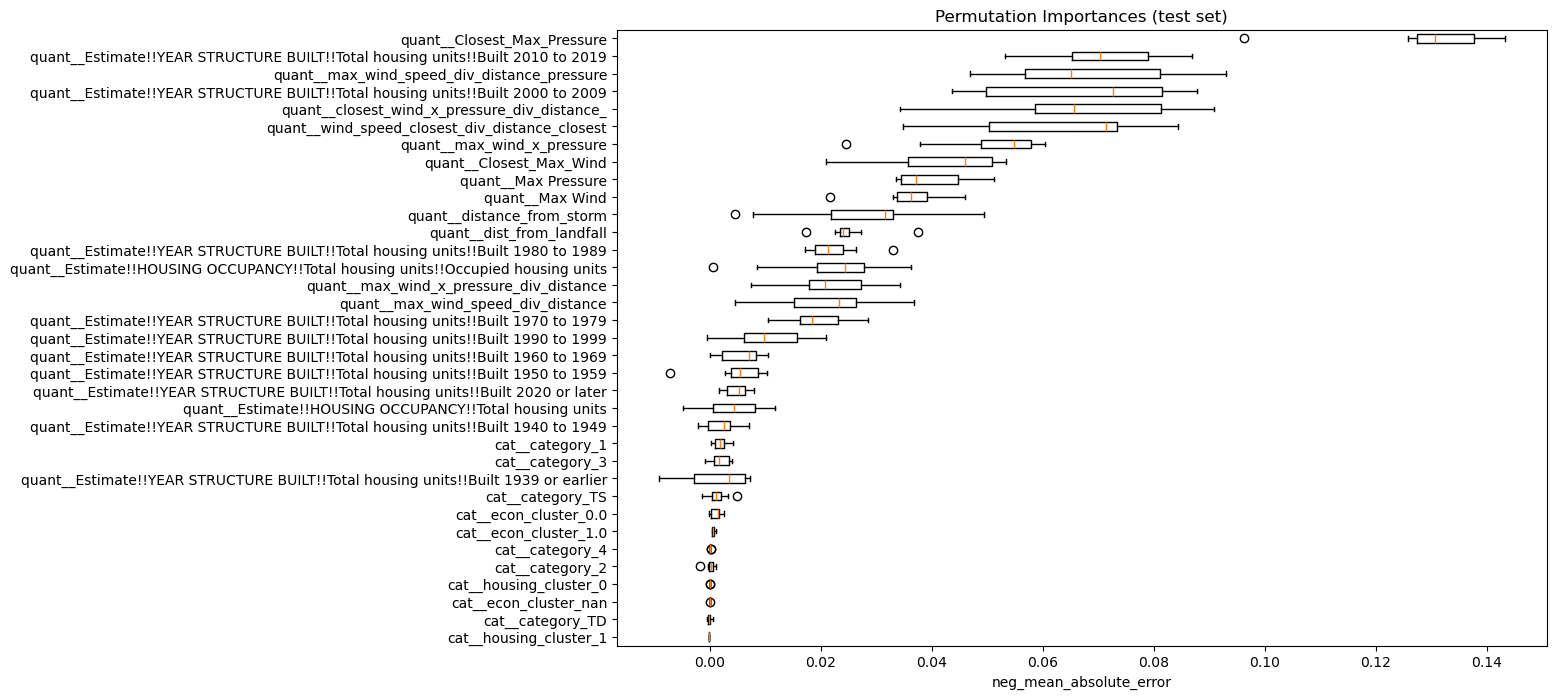

In [83]:
display_feature_importance(new_best_model_rfr,
                           X_train,
                           X_test,
                           y_train,
                           y_test)

Create learning curves plot by iterating over values for train_size.

In [646]:
learning_curves = []
ratios = [.1, .2, .3, .4, .5, .6, .7, .8,]
ratios.reverse()

for j in ratios:
    score_list = []
    X_train_r, X_test_r, y_train_r, y_test_r, _ = transformed_train_test_split(X_,
                                                            y,
                                                            j,
                                                            50,
                                                            pipe,
                                                            groups,
                                                            )
    clf = best_model_rfr
    scores = cross_val_score(clf,
                            X_train_r,
                            y_train_r,
                            cv = skfold.split(X_train_r, _),
                            scoring = 'neg_mean_absolute_error',
                            n_jobs = -1,
                            )
    score_list.append(scores)
    learning_curves.append((1-j, -np.mean(scores), np.std(scores)))
    print(f'Train size: {1-j}')    
    print(f'Mean MAE: {-np.mean(score_list)}')
    print(f'STD MAE: {np.std(score_list)}')


/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/model_selection/_split.py:805: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=10.



Train size: 0.19999999999999996
Mean MAE: 1.167847235908659
STD MAE: 0.12095212867881926


/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/model_selection/_split.py:805: UserWarning:

The least populated class in y has only 6 members, which is less than n_splits=10.



Train size: 0.30000000000000004
Mean MAE: 1.1024311214637976
STD MAE: 0.11087133524340195


/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/model_selection/_split.py:805: UserWarning:

The least populated class in y has only 8 members, which is less than n_splits=10.



Train size: 0.4
Mean MAE: 1.0586829808951062
STD MAE: 0.08943593963163647
Train size: 0.5
Mean MAE: 1.0417894024640493
STD MAE: 0.1341561123145687
Train size: 0.6
Mean MAE: 1.0442361036691972
STD MAE: 0.08932829405751362
Train size: 0.7
Mean MAE: 1.0339455780575335
STD MAE: 0.09019977292879029
Train size: 0.8
Mean MAE: 1.004514787266295
STD MAE: 0.09468145726680523
Train size: 0.9
Mean MAE: 0.970638076295552
STD MAE: 0.07065467338082046


In [647]:
df_learning = pd.DataFrame(learning_curves,
    columns=['train_size', 'mean_mae', 'std_mae'],
    )
df_learning.tail()

,train_size,mean_mae,std_mae
3,0.5,1.041789,0.134156
4,0.6,1.044236,0.089328
5,0.7,1.033946,0.090200
6,0.8,1.004515,0.094681
7,0.9,0.970638,0.070655


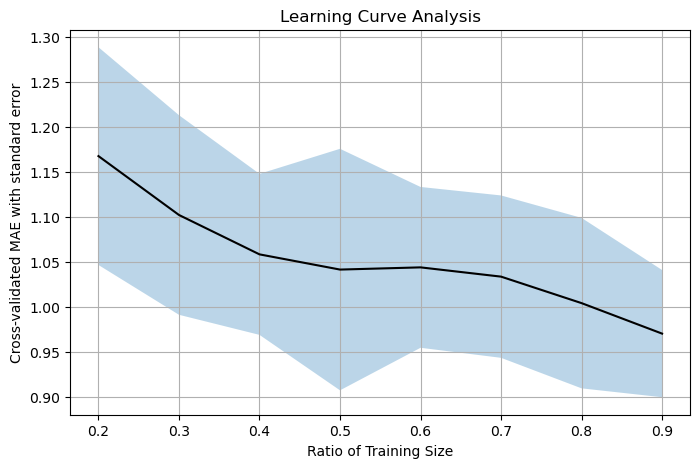

In [648]:
plt.figure(figsize=(8, 5))
plt.plot(df_learning['train_size'],
         df_learning['mean_mae'],
         color='k')
plt.fill_between(df_learning['train_size'], 
                 df_learning['mean_mae']-df_learning['std_mae'].abs(),
                 df_learning['mean_mae']+df_learning['std_mae'].abs(),
                 alpha=0.3)
plt.xlabel('Ratio of Training Size')
plt.ylabel('Cross-validated MAE with standard error')
plt.title('Learning Curve Analysis')
plt.grid(True)
plt.show()

Perform feature ablation test over multiple sets of feature groups.

In [649]:
drop_list = [
    [
        'quant__Estimate!!HOUSING OCCUPANCY!!Total housing units',
        'quant__Estimate!!HOUSING OCCUPANCY!!Total housing units!!Occupied housing units',
    ],
    [
        'quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2020 or later',
        'quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2010 to 2019',
        'quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2000 to 2009',
        'quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1990 to 1999',
        'quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1980 to 1989',
        'quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1970 to 1979',
        'quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1960 to 1969',
        'quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1950 to 1959',
        'quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1940 to 1949',
        'quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1939 or earlier',
    ],
    [
        'quant__Max Wind',
        'quant__Max Pressure',
        'quant__dist_from_landfall',
    ],
    [
        'cat__category_1',
        'cat__category_2',
        'cat__category_3',
        'cat__category_4',
        'cat__category_TD',
        'cat__category_TS',
    ],
    [
        'cat__housing_cluster_0',
        'cat__housing_cluster_1',
        'cat__econ_cluster_0.0',
        'cat__econ_cluster_1.0',
        'cat__econ_cluster_nan'
    ],
]
for item_list in drop_list:
    x_train = X_train.drop(columns=item_list)

    clf = best_model_rfr
    scores = cross_val_score(clf,
                            x_train,
                            y_train,
                            cv = skfold.split(x_train, groups_train),
                            scoring = 'neg_mean_absolute_error',
                            n_jobs = -1,
                            )
    
    print(item_list)
    print(f'Mean MAE: {-np.mean(scores)}')
    print(f'STD MAE: {np.std(scores)}')



['quant__Estimate!!HOUSING OCCUPANCY!!Total housing units', 'quant__Estimate!!HOUSING OCCUPANCY!!Total housing units!!Occupied housing units']
Mean MAE: 1.00209632834406
STD MAE: 0.09719692271549732
['quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2020 or later', 'quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2010 to 2019', 'quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2000 to 2009', 'quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1990 to 1999', 'quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1980 to 1989', 'quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1970 to 1979', 'quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1960 to 1969', 'quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1950 to 1959', 'quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1940 to 1949', 'quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!

Perform SHAP analysis, including reviews of biggest differences between target and prediction.

In [88]:
new_best_model_rfr.fit(X_train, y_train)

df_compare = X_test.copy()
df_compare['target'] = y_test
df_compare['prediction'] = new_best_model_rfr.predict(X_test)
df_compare['delta'] = df_compare['prediction'] - df_compare['target']
df_compare = df_compare.assign(entry=range(1, len(df_compare)+1))
print(df_compare[df_compare['delta'].abs()>2].shape)
df_compare.sort_values(by='delta',
                       ascending=False).head()

(39, 39)


,quant__Estimate!!HOUSING OCCUPANCY!!Total housing units,quant__Estimate!!HOUSING OCCUPANCY!!Total housing units!!Occupied housing units,quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2020 or later,quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2010 to 2019,quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2000 to 2009,quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1990 to 1999,quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1980 to 1989,quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1970 to 1979,quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1960 to 1969,quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1950 to 1959,...,cat__category_TS,cat__housing_cluster_0,cat__housing_cluster_1,cat__econ_cluster_0.0,cat__econ_cluster_1.0,cat__econ_cluster_nan,target,prediction,delta,entry
787,1.036474,0.842015,-0.202828,-0.232762,0.457155,1.227218,1.045482,1.366427,1.653219,1.004801,...,0.0,1.0,0.0,1.0,0.0,0.0,1.386294,6.040291,4.653997,272
1522,0.242484,0.107228,-0.202828,-0.232762,0.376743,0.908493,0.357414,0.051646,0.022638,-0.063177,...,0.0,1.0,0.0,1.0,0.0,0.0,1.098612,5.397192,4.298580,120
808,0.552393,0.599277,0.521898,0.895096,0.675361,0.630437,0.586932,0.478820,0.217100,0.224424,...,0.0,1.0,0.0,1.0,0.0,0.0,2.079442,6.259254,4.179812,345
1519,0.147022,0.106799,-0.202828,-0.232762,0.003425,0.300064,0.249821,0.212597,0.234020,0.173070,...,0.0,1.0,0.0,1.0,0.0,0.0,1.945910,5.655374,3.709464,178
140,0.699389,0.520077,-0.202828,-0.232762,-0.170119,-0.168081,-0.103978,0.222968,0.785368,1.199030,...,0.0,1.0,0.0,1.0,0.0,0.0,0.000000,3.334140,3.334140,118


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6a6374cd-5e77-49b2-b1d3-d73b9b2f23ac' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>

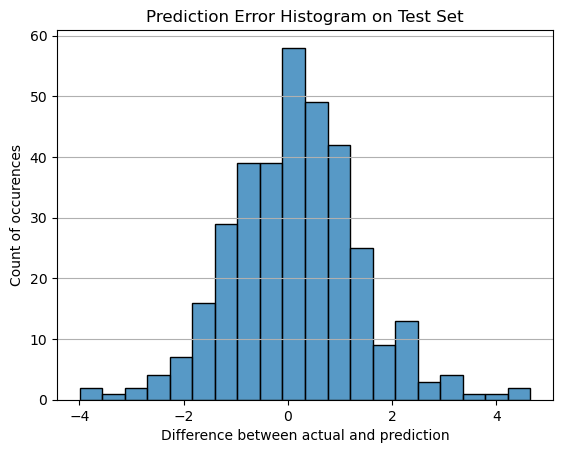

In [92]:
sns.histplot(data=df_compare,
             x = 'delta')
plt.title('Prediction Error Histogram on Test Set')
plt.xlabel('Difference between actual and prediction')
plt.ylabel('Count of occurences')
plt.grid(axis='y')
plt.show()

(39, 39)


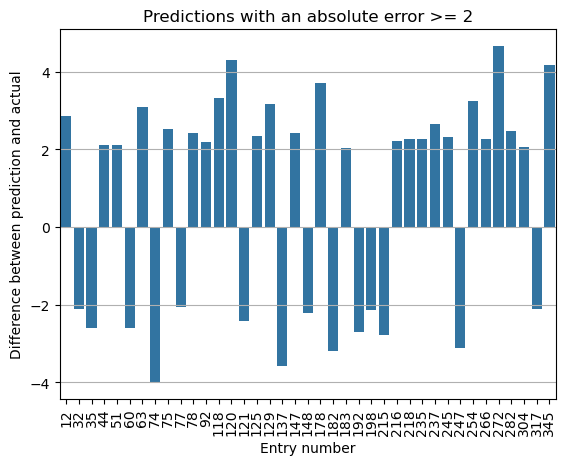

In [651]:
print(df_compare[df_compare['delta'].abs()>2].shape)
sns.barplot(data = df_compare[df_compare['delta'].abs()>2],
            x = 'entry',
            y = 'delta'
            )
plt.title('Predictions with an absolute error >= 2')
plt.ylabel('Difference between prediction and actual')
plt.xlabel('Entry number')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.show()

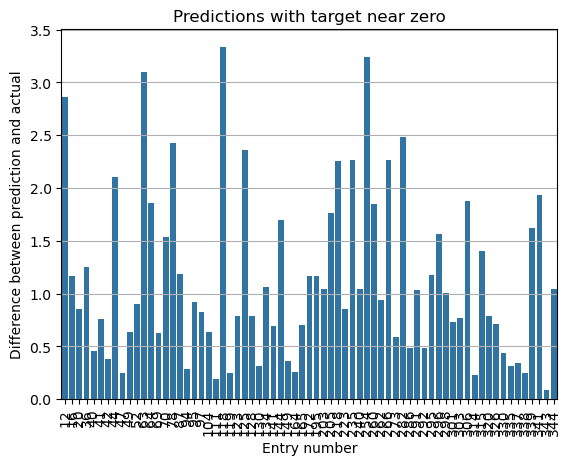

In [652]:
sns.barplot(data = df_compare[df_compare['target']<0.1],
            x = 'entry',
            y='delta'
            )
plt.title('Predictions with target near zero')
plt.ylabel('Difference between prediction and actual')
plt.xlabel('Entry number')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.show()

In [653]:
df_largest_deltas = df_compare[df_compare['delta'].abs()>3]
df_largest_deltas

,quant__Estimate!!HOUSING OCCUPANCY!!Total housing units,quant__Estimate!!HOUSING OCCUPANCY!!Total housing units!!Occupied housing units,quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2020 or later,quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2010 to 2019,quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2000 to 2009,quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1990 to 1999,quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1980 to 1989,quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1970 to 1979,quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1960 to 1969,quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1950 to 1959,...,cat__category_TS,cat__housing_cluster_0,cat__housing_cluster_1,cat__econ_cluster_0.0,cat__econ_cluster_1.0,cat__econ_cluster_nan,target,prediction,delta,entry
1598,-0.045599,-0.034327,-0.202828,-0.232762,-0.207446,0.077188,-0.014980,0.004858,0.053718,-0.044824,...,0.0,1.0,0.0,1.0,0.0,0.0,0.000000,3.098694,3.098694,63
1657,-0.374949,-0.355989,-0.202828,-0.232762,-0.405874,-0.441618,-0.361349,-0.312832,-0.325727,-0.316165,...,1.0,1.0,0.0,1.0,0.0,0.0,5.017280,1.019447,-3.997833,74
140,0.699389,0.520077,-0.202828,-0.232762,-0.170119,-0.168081,-0.103978,0.222968,0.785368,1.199030,...,0.0,1.0,0.0,1.0,0.0,0.0,0.000000,3.334140,3.334140,118
1522,0.242484,0.107228,-0.202828,-0.232762,0.376743,0.908493,0.357414,0.051646,0.022638,-0.063177,...,0.0,1.0,0.0,1.0,0.0,0.0,1.098612,5.397192,4.298580,120
804,-0.325233,-0.305329,0.040916,-0.095167,-0.274533,-0.327645,-0.379336,-0.341295,-0.327707,-0.307794,...,0.0,1.0,0.0,1.0,0.0,0.0,1.386294,4.565901,3.179606,129
56,-0.427855,-0.421717,-0.202828,-0.193082,-0.382382,-0.464815,-0.434107,-0.402431,-0.395268,-0.362690,...,0.0,1.0,0.0,1.0,0.0,0.0,4.890349,1.305031,-3.585318,137
1519,0.147022,0.106799,-0.202828,-0.232762,0.003425,0.300064,0.249821,0.212597,0.234020,0.173070,...,0.0,1.0,0.0,1.0,0.0,0.0,1.945910,5.655374,3.709464,178
1535,-0.048342,-0.049471,-0.068379,0.123247,-0.090404,-0.188968,-0.177061,-0.060567,-0.004903,0.121393,...,0.0,1.0,0.0,1.0,0.0,0.0,6.037871,2.849160,-3.188711,182
341,-0.088617,-0.072845,-0.202828,-0.128385,-0.168587,0.110426,-0.111490,-0.081348,-0.146805,-0.061808,...,1.0,1.0,0.0,1.0,0.0,0.0,5.433722,2.330733,-3.102989,247
53,-0.383854,-0.372378,-0.202828,-0.166188,-0.355965,-0.475660,-0.422332,-0.360088,-0.337547,-0.228589,...,0.0,1.0,0.0,1.0,0.0,0.0,0.000000,3.240612,3.240612,254


In [654]:
X_train.to_csv('xtrain.csv')
X_test.to_csv('xtest.csv')
y_train.to_csv('ytrain.csv')
y_test.to_csv('ytest.csv')


In [655]:
explainer = shap.Explainer(new_best_model_rfr, X_train)


In [656]:
shap_vals = explainer(X_test, check_additivity=False)


In [657]:
df_compare[df_compare['delta'].abs()>3.5]


,quant__Estimate!!HOUSING OCCUPANCY!!Total housing units,quant__Estimate!!HOUSING OCCUPANCY!!Total housing units!!Occupied housing units,quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2020 or later,quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2010 to 2019,quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2000 to 2009,quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1990 to 1999,quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1980 to 1989,quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1970 to 1979,quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1960 to 1969,quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1950 to 1959,...,cat__category_TS,cat__housing_cluster_0,cat__housing_cluster_1,cat__econ_cluster_0.0,cat__econ_cluster_1.0,cat__econ_cluster_nan,target,prediction,delta,entry
1657,-0.374949,-0.355989,-0.202828,-0.232762,-0.405874,-0.441618,-0.361349,-0.312832,-0.325727,-0.316165,...,1.0,1.0,0.0,1.0,0.0,0.0,5.017280,1.019447,-3.997833,74
1522,0.242484,0.107228,-0.202828,-0.232762,0.376743,0.908493,0.357414,0.051646,0.022638,-0.063177,...,0.0,1.0,0.0,1.0,0.0,0.0,1.098612,5.397192,4.298580,120
56,-0.427855,-0.421717,-0.202828,-0.193082,-0.382382,-0.464815,-0.434107,-0.402431,-0.395268,-0.362690,...,0.0,1.0,0.0,1.0,0.0,0.0,4.890349,1.305031,-3.585318,137
1519,0.147022,0.106799,-0.202828,-0.232762,0.003425,0.300064,0.249821,0.212597,0.234020,0.173070,...,0.0,1.0,0.0,1.0,0.0,0.0,1.945910,5.655374,3.709464,178
787,1.036474,0.842015,-0.202828,-0.232762,0.457155,1.227218,1.045482,1.366427,1.653219,1.004801,...,0.0,1.0,0.0,1.0,0.0,0.0,1.386294,6.040291,4.653997,272
808,0.552393,0.599277,0.521898,0.895096,0.675361,0.630437,0.586932,0.478820,0.217100,0.224424,...,0.0,1.0,0.0,1.0,0.0,0.0,2.079442,6.259254,4.179812,345


In [658]:
row_1522 = explainer(X_test.loc[1522])
row_1657 = explainer(X_test.loc[1657])
row_808 = explainer(X_test.loc[808])


In [659]:
shap.initjs()
shap.plots.force(row_1522)

In [660]:
shap.plots.force(row_1657)


In [661]:
shap.plots.force(row_808)


Review some of the better predictions.

In [662]:
df_compare[df_compare['delta'].abs()<.1].sort_values(by='delta',
                                                    ascending=True)


,quant__Estimate!!HOUSING OCCUPANCY!!Total housing units,quant__Estimate!!HOUSING OCCUPANCY!!Total housing units!!Occupied housing units,quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2020 or later,quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2010 to 2019,quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2000 to 2009,quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1990 to 1999,quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1980 to 1989,quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1970 to 1979,quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1960 to 1969,quant__Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1950 to 1959,...,cat__category_TS,cat__housing_cluster_0,cat__housing_cluster_1,cat__econ_cluster_0.0,cat__econ_cluster_1.0,cat__econ_cluster_nan,target,prediction,delta,entry
1328,-0.314585,-0.296705,-0.202828,-0.232762,-0.384007,-0.409083,-0.366181,-0.300394,-0.198045,-0.127168,...,0.0,1.0,0.0,1.0,0.0,0.0,2.639057,2.539998,-0.099059,4
1111,-0.453257,-0.442096,-0.202828,-0.230538,-0.415020,-0.489768,-0.458386,-0.409878,-0.409968,-0.396658,...,0.0,1.0,0.0,0.0,1.0,0.0,3.806662,3.717768,-0.088895,107
14,-0.200487,-0.192348,0.165390,0.174254,-0.205357,-0.370473,-0.244702,-0.209352,-0.141225,-0.106160,...,1.0,1.0,0.0,1.0,0.0,0.0,1.945910,1.869411,-0.076499,208
820,-0.402468,-0.388201,-0.072716,-0.178141,-0.356430,-0.442070,-0.409746,-0.393229,-0.342887,-0.348362,...,0.0,1.0,0.0,1.0,0.0,0.0,1.945910,1.884101,-0.061809,279
629,-0.450016,-0.435755,-0.202828,-0.232762,-0.425977,-0.513919,-0.450225,-0.409254,-0.409788,-0.378064,...,1.0,1.0,0.0,1.0,0.0,0.0,1.386294,1.326521,-0.059773,209
980,3.726079,3.876619,-0.202828,1.986124,5.339728,4.334733,3.981193,2.806171,2.442110,2.852028,...,1.0,1.0,0.0,1.0,0.0,0.0,1.791759,1.757370,-0.034389,76
1027,-0.328511,-0.340647,-0.202828,-0.172095,-0.230752,-0.372933,-0.349981,-0.291387,-0.248146,-0.323812,...,0.0,1.0,0.0,0.0,1.0,0.0,1.098612,1.068656,-0.029956,24
756,-0.256902,-0.252447,-0.202828,-0.232762,-0.372679,-0.336983,-0.272473,-0.245808,-0.175365,-0.118958,...,0.0,1.0,0.0,1.0,0.0,0.0,0.693147,0.667568,-0.025579,275
74,-0.283355,-0.271753,-0.202828,-0.232762,-0.306521,-0.303143,-0.260983,-0.222531,-0.240886,-0.255876,...,1.0,1.0,0.0,1.0,0.0,0.0,2.302585,2.278591,-0.023994,50
256,0.599039,0.395572,-0.202828,0.735959,1.973642,1.300071,0.518113,-0.071757,-0.231586,-0.222633,...,1.0,1.0,0.0,1.0,0.0,0.0,4.356709,4.333417,-0.023291,55


In [663]:
row_897 = explainer(X_test.loc[897])
shap.plots.force(row_897)


View spread of SHAP values versus feature value to find areas of failure.

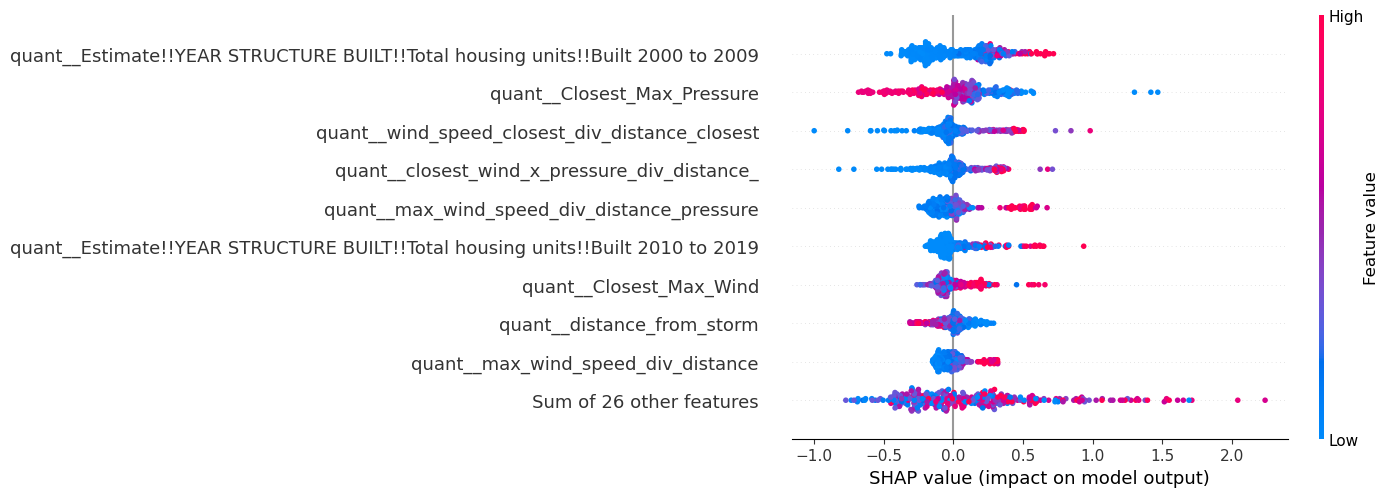

In [664]:
shap.plots.beeswarm(shap_vals)